In [1]:
from torchvision import transforms, datasets, models
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import time
from tempfile import TemporaryDirectory

In [2]:
plt.style.use("ggplot")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = torch.tensor([0.485, 0.456, 0.406]), std = torch.tensor([0.229, 0.224, 0.225]))
    ]),
    
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = torch.tensor([0.485, 0.456, 0.406]), std = torch.tensor([0.229, 0.224, 0.225]))
    ])
}

In [5]:
data_directory = "../Data/Cleaned Data"

In [6]:
image_datasets = {dataset: datasets.ImageFolder(root = os.path.join(data_directory, dataset),
                                                transform = data_transforms[dataset])
                  for dataset in ["train", "val"]}

In [7]:
classes = image_datasets["train"].classes

In [8]:
classes

['Cristiano Ronaldo',
 'Erling Haaland',
 'Kylian Mbappe',
 'Lionel Messi',
 'Neymar Jr']

In [9]:
image_dataset_sizes = {dataset: len(image_datasets[dataset]) for dataset in ["train", "val"]}

In [10]:
f"the training dataset contains {image_dataset_sizes["train"]} samples and validation dataset contains {image_dataset_sizes["val"]} samples"

'the training dataset contains 500 samples and validation dataset contains 199 samples'

In [11]:
batch_size = 4

In [12]:
dataloaders = {dataset: torch.utils.data.DataLoader(image_datasets[dataset], batch_size = batch_size, shuffle = True) for dataset in image_datasets}

In [13]:
f"each batch contains {batch_size} samples and there are total {len(dataloaders["train"])} batches in our training data and {len(dataloaders["val"])} batches in our validation data"

'each batch contains 4 samples and there are total 125 batches in our training data and 50 batches in our validation data'

In [14]:
dataiter = iter(dataloaders["train"])

In [15]:
images, labels = next(dataiter)

In [16]:
def imshow(image, labels):
    image = image.numpy().transpose((1, 2, 0))
    image = (image / 2) + 0.5
    plt.imshow(image)
    plt.title([classes[label.item()] for label in labels])
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


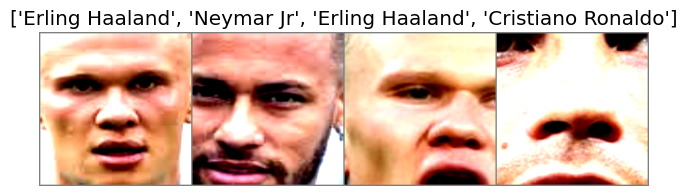

In [17]:
imshow(torchvision.utils.make_grid(images), labels)

In [18]:
model = models.resnet18(weights = "IMAGENET1K_V1")

In [19]:
size_of_last_layer = model.fc.in_features

In [20]:
f"the size of last layer i.e the number of neurons in the resnet 18 pre-trained model is {size_of_last_layer}"

'the size of last layer i.e the number of neurons in the resnet 18 pre-trained model is 512'

In [21]:
model.fc = nn.Linear(size_of_last_layer, len(classes))

In [22]:
model = model.to(device)

In [23]:
epochs = 25
learning_rate = 0.001
n_total_steps = len(dataloaders["train"])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [24]:
since = time.time()

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
    best_acc = 0.0

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
    
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                # zero the parameter gradients
                optimizer.zero_grad()
    
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
    
            epoch_loss = running_loss / image_dataset_sizes[phase]
            epoch_acc = running_corrects.double() / image_dataset_sizes[phase]
    
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
    
        print()
        
    model.load_state_dict(torch.load(best_model_params_path))
    
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

Epoch 1/25
----------
train Loss: 1.5089 Acc: 0.4120
val Loss: 5.4518 Acc: 0.0302

Epoch 2/25
----------
train Loss: 1.3687 Acc: 0.4660
val Loss: 2.3835 Acc: 0.2563

Epoch 3/25
----------
train Loss: 1.2091 Acc: 0.5120
val Loss: 0.8773 Acc: 0.6583

Epoch 4/25
----------
train Loss: 1.2294 Acc: 0.5300
val Loss: 0.7073 Acc: 0.7186

Epoch 5/25
----------
train Loss: 1.0844 Acc: 0.5960
val Loss: 0.4484 Acc: 0.8593

Epoch 6/25
----------
train Loss: 1.0804 Acc: 0.5940
val Loss: 0.4645 Acc: 0.8392

Epoch 7/25
----------
train Loss: 0.9293 Acc: 0.6740
val Loss: 0.9947 Acc: 0.6884

Epoch 8/25
----------
train Loss: 0.6661 Acc: 0.7640
val Loss: 0.3154 Acc: 0.9045

Epoch 9/25
----------
train Loss: 0.7472 Acc: 0.7300
val Loss: 0.2491 Acc: 0.9246

Epoch 10/25
----------
train Loss: 0.6688 Acc: 0.7600
val Loss: 0.1675 Acc: 0.9497

Epoch 11/25
----------
train Loss: 0.5658 Acc: 0.8180
val Loss: 0.1527 Acc: 0.9548

Epoch 12/25
----------
train Loss: 0.5485 Acc: 0.8140
val Loss: 0.2106 Acc: 0.9397

E

In [25]:
torch.save(model.state_dict(), '../models/TL_CNN_model_weights3.pth')